# Mapping Press Releases in the 2015 Canadian Federal Election using word2vec and t-SNE

The 2015 Canadian federal election was a long one (by Canadian standards anyway!). It generated a lot of press and we thought it would be a great opportunity to collect and play with that data.

Each party has a different view on what is important to move Canada forward. This has the effect of centering their official message around certain themes. The question we asked is: can we find patterns in the words used in each party’s press releases? Do some deal more with certain themes than others? Can we gain insights into their communication strategies?

This demo is based on a [blog post by François Maillet][1] from right after the campaign.

[1]: http://blog.mldb.ai/blog/posts/2015/10/election2015/

In [1]:
from pymldb import Connection
mldb = Connection()

## Importing the data

We wrote a small scraper using the [scrapy Python library](http://scrapy.org/). We scraped the press releases of the NDP, the Liberals, the Green Party and the Conservatives. The resulting data was save in a CSV file with one press release per line.

In [2]:
print mldb.post('/v1/procedures', {
    'type': 'import.text',
    'params': {
        'dataFileUrl': 'http://public.mldb.ai/datasets/press_releases/data.csv.gz',
        'outputDataset': {'type': 'sparse.mutable', 
                          'id':'raw'},
        'named': "'pr' + lineNumber()",
        'ignoreBadLines': True,
        'where': "TIMESTAMP date > TIMESTAMP '2015-08-04'"
        }
    })

<Response [201]>


Here is what the raw data look like.

In [3]:
mldb.query('SELECT * FROM raw LIMIT 5')

,date,full_text,link,party,title
_rowName,,,,,
pr816,2015-08-29T00:00:00,David Dodge The numbers dont tell you very mu...,https://www.liberal.ca/experts-agree-harper-di...,liberal,"Experts Agree: Harper distorts data, misleads ..."
pr36,2015-08-05T00:00:00,For immediate release Vote Harper to stop a Ne...,http://www.conservative.ca/no-netflix-tax/,conservative,Vote Harper to stop a Netflix Tax #nonetflixtax
pr813,2015-08-29T00:00:00,OTTAWA Today the Liberal Party of Canada lau...,https://www.liberal.ca/liberals-launch-two-can...,liberal,Liberals launch Two Candidates radio ad
pr812,2015-08-28T00:00:00,OTTAWA Stephen Harper still hasnt told Canadi...,https://www.liberal.ca/novaks-denials-raise-fr...,liberal,"Novak's denials raise fresh questions, show Ha..."
pr837,2015-09-10T00:00:00,MONTREAL The Conservative Party of Canada is ...,https://www.liberal.ca/conservative-party-demo...,liberal,Conservative Party demonstrates its disregard ...


## Exploring the data

Interested in knowing which parties have had the more press releases during the campaing? Easy!

In [4]:
mldb.query("""
SELECT count(*) as count
NAMED party
FROM raw 
GROUP BY party
ORDER BY count DESC
""")

,count
_rowName,
liberal,283
ndp,156
conservative,101
green,89


Before continuing, we will create a dataset of dummy articles that are in fact recurring themes we have observed in the data. We will add those to the data to see where they map on the final plot.

In [5]:
print mldb.post('/v1/procedures', {
    'type': 'transform',
    'params': {
        'inputData': """
        SELECT
            column AS full_text,
            column AS title,
            'keyword' AS party
        NAMED 'kw' + rowName()
        FROM (SELECT * FROM row_dataset({
            "Justin Trudeau": 1,
            "middle class": 1,
            "syrian refugees": 1,
            "terrorism": 1,
            "infrastructures": 1,
            "health": 1,
            "crime": 1,
            "jobs": 1,
            "education": 1,
            "oil": 1,
            "deficit":1,
            "youth": 1,
            "holidays": 1,
            "scandal": 1,
            "tax cuts": 1,
            "first nations": 1,
            "debate": 1,
            "small businesses": 1,
            "military": 1
            
        }))
        """,
        'outputDataset': {'id': 'keywords', 'type': 'tabular'}
    }
})

<Response [201]>


And here is what that fancy API call built

In [6]:
mldb.query('SELECT * FROM keywords LIMIT 5')

,full_text,party,title
_rowName,,,
kw9,jobs,keyword,jobs
kw8,infrastructures,keyword,infrastructures
kw7,holidays,keyword,holidays
kw6,health,keyword,health
kw5,first nations,keyword,first nations


## Creating bags of words

The next step is to take the `full_text` column and tokenize its contents. We do this because we will need to compare press releases using their content word by word.

The [`tokenize`](../../../../doc/#builtin/sql/ValueExpression.md.html#builtinfunctions) function first splits the columns into (lowercased) individual words, removing words with a length of less than 3 characters. We then remove a list of [stopwords](../../../../doc/#builtin/functions/FilterStopWords.md.html) (such as "and", "to", "the", etc.).

We do this on the [`merge`d](../../../../doc/#builtin/sql/FromExpression.md.html) dataset comprised of the press releases and of our keywords.

In [7]:
print mldb.put('/v1/functions/filter_stopwords', {
    'type': 'filter_stopwords'
})

print mldb.post('/v1/procedures', {
    'type': 'transform',
    'params': {
        'inputData': """
            SELECT
                filter_stopwords({
                    words: {
                        tokenize(
                            lower(full_text),
                            {splitChars: ' -''"?!;:/[]*,.',
                             minTokenLength: 3}
                        ) as *
                    }
                })[words] as *
            FROM merge(raw, keywords)
            WHERE party = 'keyword'
                           OR (full_text IS NOT NULL
                               AND title IS NOT NULL)
            """,
        'outputDataset': 'bag_of_words'
    }
})

<Response [201]>
<Response [201]>


The result is a clean list of words that will be easy to compare across press releases. Cells that contain a number represent the number of times that word was in the press release while cells containing `NaN` indicate that the press release did not contain the given word. Because MLDB supports sparse datasets, it is more efficient to simply not record anything when a word is not in a press release, rather than write an explicit "0" in the dataset.

In [8]:
mldb.query("SELECT * FROM bag_of_words LIMIT 5")

,aid,alleviate,assistance,budget,build,canada,canadas,canadian,canadians,cases,...,settle,shoulder,sponsors,spring,strain,subject,syrian,trust,warned,working
_rowName,,,,,,,,,,,,,,,,,,,,,
pr432,2,1,1,1,2,2,2,2,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pr611,NaN,NaN,2,NaN,NaN,NaN,NaN,1,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pr423,NaN,NaN,NaN,NaN,NaN,1,5,1,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pr809,NaN,NaN,NaN,1,1,2,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pr558,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,3,NaN,...,1,1,1,1,1,2,3,1,1,1


We can easily answer some questions from that new dataset with simple queries, like what are the most common words in our press releases.

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


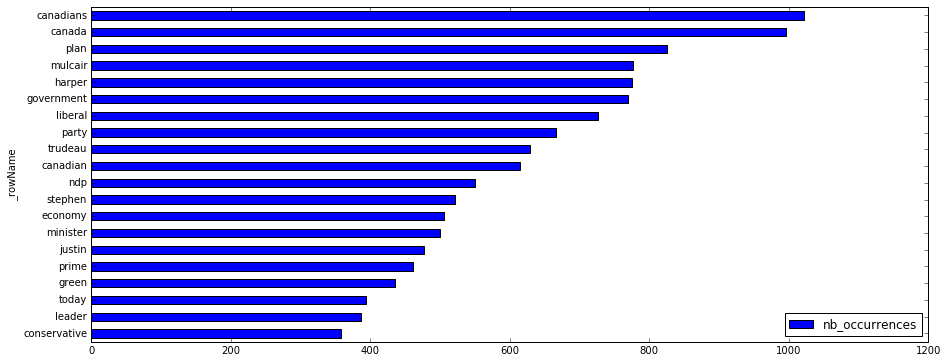

In [9]:
%matplotlib inline
mldb.query("""
SELECT *
FROM transpose((
    SELECT sum({*}) as *
    NAMED 'nb_occurrences'
    FROM bag_of_words
    WHERE rowName() NOT LIKE 'kw%' -- ignoring the keyword rows we added
))
ORDER BY nb_occurrences DESC
LIMIT 20
""").sort_values('nb_occurrences', ascending=True).plot(kind='barh', figsize=(15,6))

## Use word2vec to embed our bag of words

The [word2vec tool](http://arxiv.org/pdf/1301.3781v3.pdf) is used to embed words into a high dimensional space. Concretely, this means that we can map words into a 300-dimensions space in which "similar" words will be close, and "dissimilar" words will be far away.

You can obtain the trained word2vec embedding [here](https://code.google.com/p/word2vec). Since the original data is quite big, and we really just need a small subset of it (the coordinates for the words that actually appear in our press releases), we are going to load only that portion, that we have extracted beforehand.

### Load (a subset of) the trained word2vec data

In [10]:
print mldb.post('/v1/procedures', {
    'type': 'import.text',
    'params': {
        'dataFileUrl': 'http://public.mldb.ai/datasets/press_releases/GoogleNewsEmbedding_ElectionsDemo.csv.gz',
        'outputDataset': 'w2v',
        'select': '* EXCLUDING(word)',
        'named': 'word'
    }
})

<Response [201]>


Here is what it looks like.

In [11]:
mldb.query("SELECT * FROM w2v LIMIT 5")

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
_rowName,,,,,,,,,,,,,,,,,,,,,
preoccupied,0.527344,0.333984,-0.080078,0.102539,-0.369141,0.386719,0.339844,-0.247070,0.128906,-0.142578,...,-0.145508,-0.083984,0.154297,0.008606,-0.365234,-0.189453,-0.036621,0.010315,0.141602,0.194336
prepare,-0.143555,0.216797,0.013916,-0.241211,0.034180,0.084961,-0.206055,-0.014343,0.025635,-0.162109,...,-0.324219,-0.201172,-0.298828,0.063965,-0.032715,-0.108398,-0.143555,-0.046631,0.042480,-0.018066
prepared,-0.132812,0.138672,0.049561,-0.040283,-0.115723,0.027466,0.011292,-0.036865,0.173828,-0.078125,...,-0.296875,-0.330078,-0.298828,0.094727,-0.079590,0.000805,-0.105957,0.036865,-0.035645,-0.215820
preparedness,0.081055,0.095703,0.151367,0.089355,0.035889,0.083008,-0.089355,-0.162109,0.394531,-0.115234,...,-0.376953,-0.285156,-0.277344,0.022705,0.215820,-0.149414,-0.000492,-0.208008,-0.109863,0.152344
prepares,0.215820,0.238281,0.117676,-0.333984,-0.007935,-0.102539,-0.044189,-0.166016,0.038818,-0.106934,...,-0.298828,-0.449219,-0.384766,0.185547,-0.246094,0.075684,0.156250,0.012695,0.043945,0.158203


### Compute the embedding for all press releases

Word2vec gives us word embeddings, but since we are interested is press releases, we need to find a way to embed the document itself in the space. The most obvious way is to take the centroid of all the words in a document as the representation of that document in the 300-dimensions space.

We can achieve this using a [`pooling` function](../../../../doc/#builtin/functions/Pooling.md.html).

In [12]:
print mldb.put('/v1/functions/pool', {
    'type': 'pooling',
    'params': {
        'aggregators': ['avg'],
        'embeddingDataset': 'w2v'
    }
})

<Response [201]>


In [13]:
print mldb.post('/v1/procedures', {
    'type': 'transform',
    'params': {
        'inputData': """
            SELECT pool({words: {*}})[embedding] AS *
            FROM bag_of_words
        """,
        'outputDataset': 'word2vec'
    }
})

<Response [201]>


In the new `word2vec` dataset, each row is still a press release and the columns are the word2vec coordinates.

In [14]:
mldb.query("SELECT * FROM word2vec LIMIT 5")

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
_rowName,,,,,,,,,,,,,,,,,,,,,
pr865,0.032759,0.019920,0.006550,0.078991,-0.036144,-0.028015,-0.065795,-0.097013,0.065641,0.042858,...,-0.055686,-0.054643,-0.111739,0.002409,0.049028,-0.095925,0.054815,-0.028988,0.009976,0.072976
pr107,0.021380,0.057331,-0.001837,0.093658,-0.047274,-0.076754,0.024035,-0.061771,0.096272,0.053844,...,-0.111051,0.037341,-0.068267,-0.008281,-0.063625,0.036184,0.020795,0.003599,0.057439,-0.046436
pr896,-0.019961,0.041906,0.011823,0.085196,-0.022192,-0.036619,0.022390,-0.045063,0.084555,0.008020,...,-0.101178,0.041783,-0.078824,0.016356,-0.018967,0.017145,-0.025893,-0.007047,0.081595,-0.054728
pr607,-0.030708,0.021404,0.012121,0.063508,-0.028359,-0.103746,0.012344,-0.067797,0.091136,0.031186,...,-0.077244,0.038484,-0.052104,0.013892,-0.066669,0.011444,0.015818,-0.017750,0.007186,-0.012422
pr249,-0.012412,0.034083,-0.012667,0.034469,-0.007789,-0.042657,0.013638,-0.087379,0.070248,0.029023,...,-0.143397,0.030871,-0.095722,0.003331,-0.016976,0.007648,0.040113,-0.035733,0.060266,0.003928


## Use t-SNE for dimensionality reduction

The [t-SNE algorithm](http://lvdmaaten.github.io/tsne/) is a very powerful technique that can be used to reduce the dimensionality of data to 2D or 3D, typically to visualize it. We will use it to map our press releases on a 2D scatter plot.

In [15]:
print mldb.post('/v1/procedures', {
    'type': 'tsne.train',
    'params': {
        'trainingData': 'SELECT * FROM word2vec',
        'rowOutputDataset': 'tsne',
        'perplexity': 5,
        'modelFileUrl': 'file://pr_tsne.bin.gz'
    }
})

<Response [201]>


In [16]:
mldb.query("SELECT * FROM tsne LIMIT 5")

,x,y
_rowName,,
pr189,-20.069212,-13.740768
pr201,-26.396029,-36.491875
pr19,15.770018,-51.777973
pr803,22.519440,48.915726
pr915,-44.215103,-74.324722


## Doing the scatter plot

We now have the `tsne` dataset that represents all of our press releases with $(x,y)$ coordinates in the embedding space. It is now very easy to merge those coordinates with both the press releases and our keywords.

In [17]:
pr = mldb.query("""
SELECT raw.title as title, raw.party as party, tsne.x as x, tsne.y as y
NAMED raw.rowName()
FROM raw
JOIN tsne
ON tsne.rowName() = raw.rowName()
""")
kw = mldb.query("""
SELECT keywords.party as party, keywords.title as title, tsne.x as x, tsne.y as y
NAMED keywords.rowName()
FROM keywords
JOIN tsne
ON tsne.rowName() = keywords.rowName()
""")
pr[:5]

,party,title,x,y
_rowName,,,,
pr10,conservative,Conservatives Target World's Human Rights Abus...,13.226810,-48.083923
pr100,conservative,Hold On To Your Wallet: Justin Trudeau's Real ...,16.333181,38.655582
pr101,conservative,Statement by the Prime Minister of Canada to c...,66.167328,-38.826836
pr102,conservative,Statement by Stephen Harper to mark the start ...,69.897781,-37.149445
pr103,conservative,Harper Announces Further Actions To Combat Hum...,23.277555,-89.836121


And now let's create our final plot! We simply use [Bokeh](http://bokeh.pydata.org) to make a scatter plot of the press releases, where we color each point by the color of its party. We then add our keywords on top of that, using the coordinates given by t-SNE.

In [18]:
import bokeh.plotting as bp
from bokeh.models import HoverTool

In [19]:
#this line must be in its own cell 
bp.output_notebook()

Loading BokehJS ...

In [20]:
fig = bp.figure(
    plot_width=900, plot_height=700, x_axis_type=None, y_axis_type=None, min_border=1,
    title="Press Releases of Canadian Federal Parties During 2015 Elections",
    tools = [HoverTool(tooltips=[('title', '@title')])], toolbar_location=None
)

# the colored points
colormap = {"ndp": "#FF8000", "liberal": "#DF0101", "conservative": "#0000FF", "green": "#01DF01"}
for party, color in colormap.iteritems():
    fig.scatter(
        x='x', y='y', color=color, radius=1, fill_alpha=0.5, legend=party,
        source=bp.ColumnDataSource(pr[pr['party'] == party])
    )

# add some subtle white background for the text to be more visible
fig.rect(
    x='x', y='y', color='white', alpha=.6, height=5,
    width = [1 + len(w)*2.5 for w in kw['title'].values],  # heuristic
    source=bp.ColumnDataSource(kw)
)

# the keywords on top of the scatter plot
fig.text(
    x='x', y='y', text='title', text_font_size='11pt', text_color='black', text_font='courier',
    text_align='center', text_baseline='middle',  source=bp.ColumnDataSource(kw)
)

bp.show(fig)

This plot is interactive. You can explore it by hovering over the different press releases and the tooltip will show the title of each press release. Now have fun spotting thematic biases across parties!